In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import sys
import os
import subprocess

In [2]:
directory = "../simulations/msd_validation_actual/"

In [3]:
%cd $directory

/home/ian/Projects/work/md-lv/simulations/msd_validation_actual


In [4]:
pwd

'/home/ian/Projects/work/md-lv/simulations/msd_validation_actual'

In [24]:
seed = 0

In [132]:
for vol in np.linspace(5.0, 11.0, 13):
    print(vol)
    for realization in np.arange(90):
        os.system(f"./../../target/release/md-lv -v {vol} -s 1000000 -t 0.01 -o 100 -i 1000000 --seed {seed}")
        seed += 1

5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0
10.5
11.0


In [19]:
seed

220

In [5]:
def fetch_xyz(file, dim=2):
    assert(dim==2 or dim==3)
    output = []
    with open(file, "r") as xyz:
        try:
            while True:
                N = int(xyz.readline())
                xyz.readline()
                arr = np.empty((N, dim))
                for i in np.arange(N):
                    line = xyz.readline()
                    _, x, y, _ = line.split()
                    if dim == 2:
                        arr[i] = np.array([float(x), float(y)])
                    else:
                        arr[i] = np.array([float(x), float(y), float(z)])
                output.append(arr)
        except:
            pass
    return np.array(output)

In [6]:
def msd_simple(traj, ref=0):
    shape = traj.shape
    timesteps = shape[0]
    N = shape[1]
    oN = 1/N
    dim = shape[2]

    msd = np.zeros((timesteps-ref))
    for i in np.arange(ref, timesteps):
        msd[i] = np.mean(np.square(np.linalg.norm(traj[i] - traj[ref], axis=-1)))
    return msd

def msd_wrap(traj, V, ref=0):
    L=np.sqrt(V)
    L2 = L/2
    shape = traj.shape
    timesteps = shape[0]
    N = shape[1]
    oN = 1/N
    dim = shape[2]

    wrap = np.zeros((N, dim))

    msd = np.zeros((timesteps-ref-1))
    for i in np.arange(ref+1, timesteps):
        diff = traj[i] - traj[i-1]
        cond1 = diff > L2
        cond2 = diff < -L2
        wrap += cond2.astype(int) - cond1.astype(int)

        msd[i-ref-1] = np.mean(np.square(np.linalg.norm(traj[i] + L*wrap - traj[ref], axis=-1)))
    return msd, wrap

def msd_wrap_drift(traj, V, ref=0):
    L=np.sqrt(V)
    L2 = L/2
    shape = traj.shape
    timesteps = shape[0]
    N = shape[1]
    oN = 1/N
    dim = shape[2]

    wrap = np.zeros((N, dim))

    msd = np.zeros((timesteps-ref-1))
    for i in np.arange(ref+1, timesteps):
        diff = traj[i] - traj[i-1]
        cond1 = diff > L2
        cond2 = diff < -L2
        wrap += cond2.astype(int) - cond1.astype(int)

        move = traj[i] + L*wrap - traj[ref]

        drift = np.mean(move, axis=0)

        msd[i-ref-1] = np.mean(np.square(np.linalg.norm(move-drift, axis=-1)))
    return msd, wrap

In [7]:
import glob

In [8]:
files = sorted(glob.glob("traj_*t0.0001*_step1000000_*"))

In [9]:
files

['traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6010_out100.xyz',
 'traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6011_out100.xyz',
 'traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6012_out100.xyz',
 'traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6013_out100.xyz',
 'traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6014_out100.xyz',
 'traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6015_out100.xyz',
 'traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6016_out100.xyz',
 'traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6017_out100.xyz',
 'traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6018_out100.xyz',
 'traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6019_out100.xyz',
 'traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6110_out100.xyz',
 'traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6111_out100.xyz',
 'traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6112_out100.xyz',
 'traj_n10_v11_t0.0001_step1000000_dt0.001_visc5_seed6113_out100.xyz',
 'traj

In [23]:
len(files)

200

In [11]:
from collections import defaultdict

In [38]:
msd_data = defaultdict(list)
for i in np.arange(len(files)):
    if i%100 == 0:
        print(len(files), i)
    f = files[i]
    vol = float(f.split("_")[2][1:])
    xyz = fetch_xyz(f)
    msd_t, _ = msd_wrap(xyz, vol, ref=100)
    msd_data[vol].append(msd_t)

1300 0
1300 100
1300 200
1300 300
1300 400
1300 500
1300 600
1300 700
1300 800
1300 900
1300 1000
1300 1100
1300 1200


In [12]:
msd_data_drift = defaultdict(list)
for i in np.arange(len(files)):
    if i%100 == 0:
        print(len(files), i)
    f = files[i]
    vol = float(f.split("_")[2][1:])
    xyz = fetch_xyz(f)
    msd_t, _ = msd_wrap_drift(xyz, vol, ref=100)
    msd_data_drift[vol].append(msd_t)

200 0
200 100


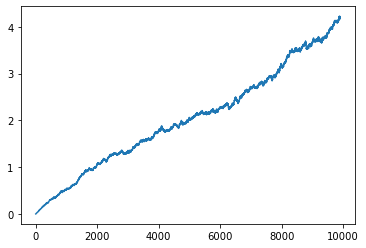

In [158]:
plt.plot(np.mean(msds, axis=0))

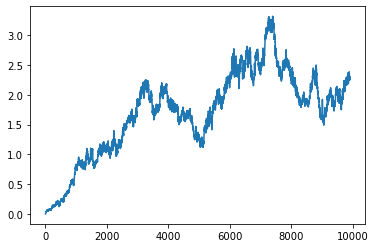

In [155]:
plt.plot(msds[2])

In [51]:
msd_t

In [39]:
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=5, vmax=11)
max_t = 500
for label, dat in msd_data.items():
    plt.plot(np.linspace(0, dat[0].shape[-1]/10, dat[0].shape[-1])[:max_t], np.mean(dat, axis=0), color=cmap(norm(label)), alpha=1)
plt.xlabel("time [s]")
plt.ylabel(r"MSD [$\sigma$]")
plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), label="Box Area")


NameError: name 'msd_data' is not defined

In [44]:
files[0]

'traj_n10_v10.5_t0.01_step1000000_dt0.001_visc5_seed1000_out100.xyz'

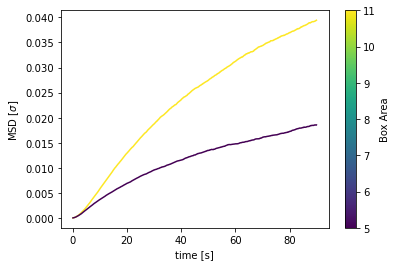

In [22]:
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=5, vmax=11)
max_t = 900
for label, dat in msd_data_drift.items():
    plt.plot(np.linspace(0, dat[0].shape[-1]/10, dat[0].shape[-1])[:max_t], np.mean(dat, axis=0)[:max_t], color=cmap(norm(label)), alpha=1)
    #break
plt.xlabel("time [s]")
plt.ylabel(r"MSD [$\sigma$]")
plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), label="Box Area")
plt.savefig("MSD.png")

In [35]:
dat[0].shape

(9899,)